In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
VGG_MEAN = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32)

In [3]:
from tensorflow.data import Dataset
from tensorflow.python.framework import dtypes
from tensorflow.python.framework.ops import convert_to_tensor
class ImageDataGenerator(object):
    """Wrapper class around the new Tensorflows dataset pipeline.

    Requires Tensorflow >= version 1.12rc0
    """

    def __init__(self, txt_file, mode, batch_size, num_classes, shuffle=True,
                 buffer_size=1000):
        """Create a new ImageDataGenerator.

        Recieves a path string to a text file, which consists of many lines,
        where each line has first a path string to an image and seperated by
        a space an integer, referring to the class number. Using this data,
        this class will create TensrFlow datasets, that can be used to train
        e.g. a convolutional neural network.

        Args:
            txt_file: Path to the text file.
            mode: Either 'training' or 'validation'. Depending on this value,
                different parsing functions will be used.
            batch_size: Number of images per batch.
            num_classes: Number of classes in the dataset.
            shuffle: Wether or not to shuffle the data in the dataset and the
                initial file list.
            buffer_size: Number of images used as buffer for TensorFlows
                shuffling of the dataset.

        Raises:
            ValueError: If an invalid mode is passed.

        """
        self.txt_file = txt_file
        self.num_classes = num_classes

        # retrieve the data from the text file
        self._read_txt_file()

        # number of samples in the dataset
        self.data_size = len(self.labels)

        # initial shuffling of the file and label lists (together!)
        if shuffle:
            self._shuffle_lists()

        # convert lists to TF tensor
        self.img_paths = convert_to_tensor(self.img_paths, dtype=dtypes.string)
        self.labels = convert_to_tensor(self.labels, dtype=dtypes.int32)

        # create dataset
        data = Dataset.from_tensor_slices((self.img_paths, self.labels))

        # distinguish between train/infer. when calling the parsing functions
        if mode == 'training':
            data = data.map(self._parse_function_train)

        elif mode == 'inference':
            data = data.map(self._parse_function_inference)

        else:
            raise ValueError("Invalid mode '%s'." % (mode))

        # shuffle the first `buffer_size` elements of the dataset
        if shuffle:
            data = data.shuffle(buffer_size=buffer_size)

        # create a new dataset with batches of images
        data = data.batch(batch_size)

        self.data = data

    def _read_txt_file(self):
        """Read the content of the text file and store it into lists."""
        self.img_paths = []
        self.labels = []
        with open(self.txt_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                items = line.split(' ')
                self.img_paths.append(items[0])
                self.labels.append(int(items[1]))

    def _shuffle_lists(self):
        """Conjoined shuffling of the list of paths and labels."""
        path = self.img_paths
        labels = self.labels
        permutation = np.random.permutation(self.data_size)
        self.img_paths = []
        self.labels = []
        for i in permutation:
            self.img_paths.append(path[i])
            self.labels.append(labels[i])

    def _parse_function_train(self, filename, label):
        """Input parser for samples of the training set."""
        # convert label number into one-hot-encoding
        one_hot = tf.one_hot(label, self.num_classes)

        # # load and preprocess the image
        img_string = tf.read_file(filename)
        img_decoded = tf.image.decode_png(img_string, channels=3)
        img_resized = tf.image.resize_images(img_decoded, [227, 227])
        """
        Dataaugmentation comes here.
        """
        img_centered = tf.subtract(img_resized, VGG_MEAN)

        # RGB -> BGR
        img_bgr = img_centered[:, :, ::-1]

        #img_string = tf.read_file(filename)
        #img = load_image_fhandle(img_string, channels = 3, expects_bgr = True)
        #img_bgr = process_image(img, scale = 227, crop = 256, horizontal_flip = True,random_crop = True)

        return img_bgr, one_hot

    def _parse_function_inference(self, filename, label):
        """Input parser for samples of the validation/test set."""
        # convert label number into one-hot-encoding
        one_hot = tf.one_hot(label, self.num_classes)

        # load and preprocess the image
        img_string = tf.read_file(filename)
        img_decoded = tf.image.decode_png(img_string, channels=3)
        img_resized = tf.image.resize_images(img_decoded, [227, 227])
        img_centered = tf.subtract(img_resized, VGG_MEAN)

        # RGB -> BGR
        img_bgr = img_centered[:, :, ::-1]

        #img_string = tf.read_file(filename)
        #img = load_image_fhandle(img_string, channels = 3,expects_bgr = True)
        #img_bgr = process_image(img, scale = 227, crop = 227)

        return img_bgr, one_hot

In [4]:
import os
labels = []
count = -1
filenames = []
for d in os.listdir('/root/Data/Furniture/'):
    count += 1
    if ('_jpg') in d:
        for f in os.listdir('/root/Data/Furniture/'+d):
            if f.endswith('.jpg'):
                filenames.append('/root/Data/Furniture/'+d+'/'+f)
                labels.append(count)

In [5]:
whos

Variable             Type        Data/Info
------------------------------------------
Dataset              ABCMeta     <class 'tensorflow.python<...>ops.dataset_ops.Dataset'>
ImageDataGenerator   type        <class '__main__.ImageDataGenerator'>
VGG_MEAN             Tensor      Tensor("Const:0", shape=(3,), dtype=float32)
convert_to_tensor    function    <function convert_to_tensor at 0x7f51bad68f50>
count                int         8
d                    str         bed_jpg
dtypes               module      <module 'tensorflow.pytho<...>on/framework/dtypes.pyc'>
f                    str         urban-home-solid-wood-kin<...>-colour-by-asian-arts.jpg
filenames            list        n=3832
labels               list        n=3832
np                   module      <module 'numpy' from '/us<...>ages/numpy/__init__.pyc'>
os                   module      <module 'os' from '/usr/lib/python2.7/os.pyc'>
plt                  module      <module 'matplotlib.pyplo<...>s/matplotlib/pyplot.pyc'>
tf  

In [6]:
zip(filenames,labels)

[('/root/Data/Furniture/lamp_jpg/shady-ideas-paisley-passion-small-table-lamp-shady-ideas-pai.jpg',
  0),
 ('/root/Data/Furniture/lamp_jpg/sylvn-studio-colosseum-table-lamp-sylvn-studio-colosseum-tab.jpg',
  0),
 ('/root/Data/Furniture/lamp_jpg/hand-painted-wood-lamp-shade-with-worli-painting-hand-painte.jpg',
  0),
 ('/root/Data/Furniture/lamp_jpg/height-of-designs-bronze-full-buddha-face-table-lamp-height-.jpg',
  0),
 ('/root/Data/Furniture/lamp_jpg/exclusivelane-canvas-handpainted-meditating-buddha-lamp-15-i.jpg',
  0),
 ('/root/Data/Furniture/lamp_jpg/Kavi-s-Knots-And-Crosses-Lamp-Kavi-s-Knots-And-Crosses-Lamp-.jpg',
  0),
 ('/root/Data/Furniture/lamp_jpg/exclusivelane-17-inch-warli-handpainted-wooden-patch-lamp-ex.jpg',
  0),
 ('/root/Data/Furniture/lamp_jpg/exclusivelane-14inch-wooden-lamp-turqouise-blue-exclusivelan.jpg',
  0),
 ('/root/Data/Furniture/lamp_jpg/exclusivelane-18-inch-terracotta-handpainted-madhubani-t_008.jpg',
  0),
 ('/root/Data/Furniture/lamp_jpg/courtyard-ban

In [7]:
p = np.random.permutation(len(filenames))
fn = filenames
l = labels
for i in p:
    filenames[i] = fn[p[i]]
    labels[i] = l[p[i]]

In [8]:
nTrain = int(0.6*len(filenames))
nVal = int(0.25*len(filenames))

In [9]:
with open('train.txt','w') as f:
    for i in range(0,int(nTrain)):
        f.write('%s %d \n' %(filenames[i],labels[i]))

In [10]:
with open('val.txt','w') as f:
    for i in range(nTrain,nTrain+nVal):
        f.write('%s %d \n' %(filenames[i],labels[i]))

In [11]:
with open('test.txt','w') as f:
    for i in range(nTrain+nVal,len(filenames)):
        f.write('%s %d \n' %(filenames[i],labels[i]))

In [12]:
len(filenames)

3832

In [14]:
traindataGen = ImageDataGenerator(txt_file='train.txt', mode = 'training', batch_size = 128, num_classes = 8,shuffle=True )
valdataGen = ImageDataGenerator(txt_file='val.txt', mode = 'inference', batch_size = 128, num_classes = 8 )
iterator = tf.data.Iterator.from_structure(traindataGen.data.output_types,traindataGen.data.output_shapes)
next_batch = iterator.get_next()
train_init_op = iterator.make_initializer(traindataGen.data)
val_init_op = iterator.make_initializer(valdataGen.data)

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(train_init_op)
    for i in range(10):
        batch_x, batch_y = sess.run(next_batch)

In [16]:
batch_x.dtype

dtype('float32')

In [17]:
im = batch_x[2,:,:,:]

In [18]:
im = im[:, :, ::-1]
im = im+np.array([123.68, 116.779, 103.939])

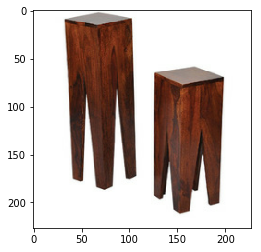

In [19]:
plt.imshow(np.uint8(im))

In [28]:
im.shape

(227, 227, 3)

In [29]:
np.argmax(batch_y[2])

0